In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from connection_complexity.data.raw_data.EDF.edf_helpers import read_edf
import os

In [2]:
mapping_path = "/media/dan/Data/manuscripts/manuiscript_0001_hfo_rates/data/FULL_composite_patient_info.csv"  
ilae_path = "/media/dan/Data/manuscripts/manuiscript_0001_hfo_rates/ravi_hfo_numbers~N59+v03.csv"
bad_channels_path = "/media/dan/Data/manuscripts/manuiscript_0001_hfo_rates/data/bad_ch_review.xlsx"
edf_path = "/media/dan/Data/data/iEEG/raw_ieeg/baseline_patients/baseline_edfs"
output_path = "/media/dan/Data/git/network_miner/connectivity/output"

pid_source_path = "/media/dan/Data/manuscripts/manuiscript_0001_hfo_rates/ravi_hfo_numbers~N59+v03.csv"


dur_msec = 500
dur_sec = dur_msec / 1000
overlap_msec = 0
overlap_sec = overlap_msec / 1000


# get metadata
mappings = pd.read_csv(mapping_path)
ilae = pd.read_csv(ilae_path)
bad_channels = pd.read_excel(bad_channels_path)
bad_channels["use"] = bad_channels["use"].fillna(1)
bad_channels["use2"] = bad_channels["use2"].fillna(1)
bad_channels["use"] = bad_channels["use"].astype(bool)
bad_channels["use2"] = bad_channels["use2"].astype(bool)

# OR bad_channel columns
bad_channels["bad_channel"] = ~(bad_channels["use"] & bad_channels["use2"])

# for each patient in mappings, find the corresponding ilae number. The patient may not be in the ilae dataset but has a designation of seizureFree or not.
# if the patient is not in the ilae dataset, then use the seizureFree column to determine the ilae number where -1 is seizureFree and 100 is not seizureFree
ilae_numbers = {}
for pid in mappings["pid"].unique():
    if pid in ilae["patient"].values:
        ilae_numbers[pid] = ilae[ilae["patient"] == pid]["ilae"].values[0]
    else:
        if mappings[mappings["pid"] == pid]["seizureFree"].values[0] == True:
            ilae_numbers[pid] = -1
        else:
            ilae_numbers[pid] = 100

# now we have a dictionary of ilae numbers for each patient. Fill in the mappings dataframe with these numbers which has multiple rows for each patient
ilae_list = []
for pid in mappings["pid"]:
    ilae_list.append(ilae_numbers[pid])
mappings["ilae"] = ilae_list


# Perform the merge as before
mappings = mappings.merge(
    bad_channels[['pid', 'ch', 'bad_channel']],
    left_on=['pid', 'electrode'],
    right_on=['pid', 'ch'],
    how='left'
)

# Drop the 'ch' column if needed
mappings = mappings.drop(columns=['ch'])

# Fill NaN values in 'bad_channel' with 0
mappings['bad_channel'] = mappings['bad_channel'].fillna(0)


In [3]:
patient_info = mappings[mappings["pid"] == 34]
pt_mappings = patient_info[patient_info["bad_channel"] == 0]
raw = read_edf(os.path.join(edf_path,"034_Baseline.EDF"))
raw = raw.drop_channels(patient_info[patient_info["bad_channel"] == 1]["electrode"].values)
channels = raw.ch_names
soz = patient_info["soz"].values
coh = np.load("/media/dan/Data/git/network_miner/connectivity/output/034_coh_winmsec-000500_overlap-000000.npy").squeeze()
pli = np.load("/media/dan/Data/git/network_miner/connectivity/output/034_pli_winmsec-000500_overlap-000000.npy").squeeze()
plv = np.load("/media/dan/Data/git/network_miner/connectivity/output/034_plv_winmsec-000500_overlap-000000.npy").squeeze()
wpli = np.load("/media/dan/Data/git/network_miner/connectivity/output/034_wpli_winmsec-000500_overlap-000000.npy").squeeze()

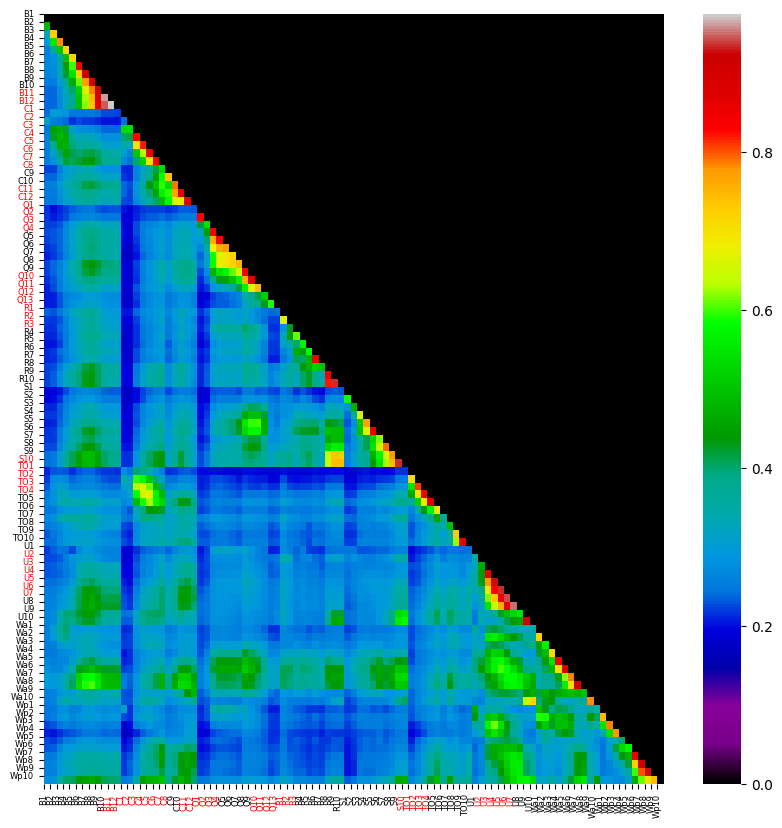

In [9]:
coh_avg = np.mean(coh, axis=0)
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(coh_avg, cmap="nipy_spectral", ax=ax)

# Replace ticks with channel names
plt.yticks(np.arange(len(channels)), channels, fontsize=6)
plt.xticks(np.arange(len(channels)), channels, fontsize=6, rotation=90)

# Make yticks for soz channels red
for i in range(len(channels)):
    if soz[i] == 1:
        ax.get_yticklabels()[i].set_color("red")
        ax.get_xticklabels()[i].set_color("red")

# plt.title(f"{measure} | Epoch {epoch:05} | Win {dur_msec}ms | Overlap {overlap_msec}ms")

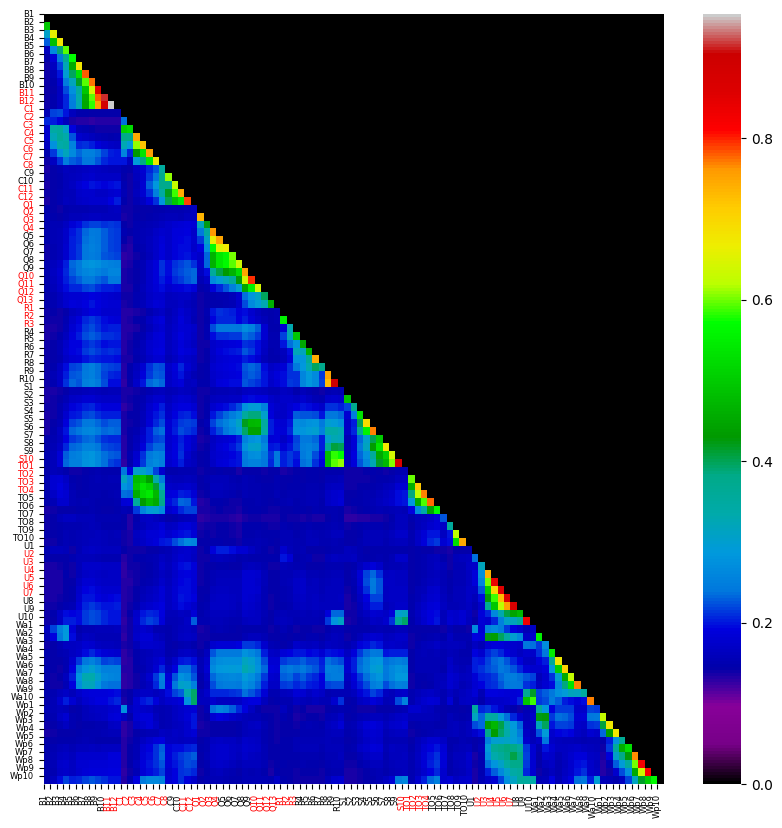

In [10]:
plv_avg = np.mean(plv, axis=0)
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(plv_avg, cmap="nipy_spectral", ax=ax)

# Replace ticks with channel names
plt.yticks(np.arange(len(channels)), channels, fontsize=6)
plt.xticks(np.arange(len(channels)), channels, fontsize=6, rotation=90)

# Make yticks for soz channels red
for i in range(len(channels)):
    if soz[i] == 1:
        ax.get_yticklabels()[i].set_color("red")
        ax.get_xticklabels()[i].set_color("red")

# plt.title(f"{measure} | Epoch {epoch:05} | Win {dur_msec}ms | Overlap {overlap_msec}ms")

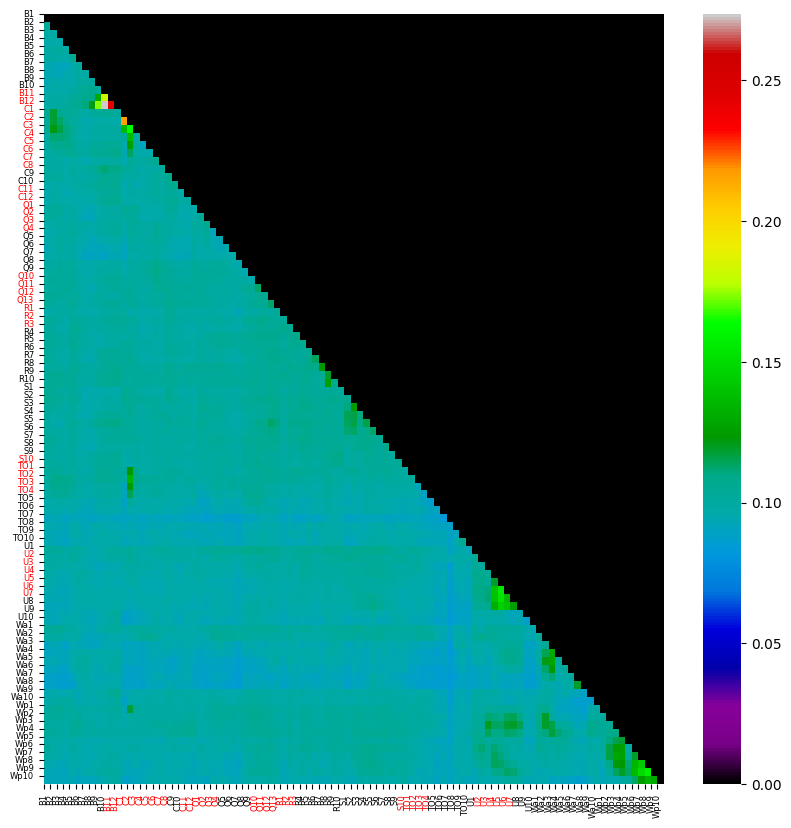

In [11]:
coh_avg = np.mean(pli, axis=0)
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(coh_avg, cmap="nipy_spectral", ax=ax)

# Replace ticks with channel names
plt.yticks(np.arange(len(channels)), channels, fontsize=6)
plt.xticks(np.arange(len(channels)), channels, fontsize=6, rotation=90)

# Make yticks for soz channels red
for i in range(len(channels)):
    if soz[i] == 1:
        ax.get_yticklabels()[i].set_color("red")
        ax.get_xticklabels()[i].set_color("red")

# plt.title(f"{measure} | Epoch {epoch:05} | Win {dur_msec}ms | Overlap {overl

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from concurrent.futures import ProcessPoolExecutor

def plot_heatmap(epoch, data, channels, soz, output_dir, measure,vmin=0,vmax=1):
    center = vmax - (vmax-vmin)/2
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(data[epoch, :, :], cmap="nipy_spectral", center=center, vmin=vmin, vmax=vmax, ax=ax)
    
    # Replace ticks with channel names
    plt.yticks(np.arange(len(channels)), channels, fontsize=6)
    plt.xticks(np.arange(len(channels)), channels, fontsize=6, rotation=90)
    
    # Make yticks for soz channels red
    for i in range(len(channels)):
        if soz[i] == 1:
            ax.get_yticklabels()[i].set_color("red")
            ax.get_xticklabels()[i].set_color("red")
    
    plt.title(f"{measure} | Epoch {epoch:05} | Win {dur_msec}ms | Overlap {overlap_msec}ms")
    output_path = os.path.join(output_dir,f"034_{measure}_win{dur_msec:05}_overlap{overlap_msec:05}_epoch{epoch:05}.png")
    plt.savefig(output_path)
    plt.close()

def parallel_plotting(data, channels, soz, output_dir, measure, vmin=0, vmax=1):
    os.makedirs(output_dir, exist_ok=True)
    if len(data.shape) == 2:
        plot_heatmap(0, data[np.newaxis,...], channels, soz, output_dir, measure, vmin, vmax)
        return

    with ProcessPoolExecutor() as executor:
        futures = [
            executor.submit(plot_heatmap, epoch, data, channels, soz, output_dir, measure, vmin, vmax)
            for epoch in range(data.shape[0])
        ]
        # Optional: Wait for all futures to complete
        for future in futures:
            future.result()


In [51]:
output_directory = "/media/dan/Data/git/network_miner/connectivity/images/034/coh"
parallel_plotting(coh, channels, soz, output_directory, "coh")

In [52]:
output_directory = "/media/dan/Data/git/network_miner/connectivity/images/034/pli"
parallel_plotting(pli, channels, soz, output_directory, "pli", vmin=0, vmax=pli.max())

In [53]:
output_directory = "/media/dan/Data/git/network_miner/connectivity/images/034/plv"
parallel_plotting(plv, channels, soz, output_directory, "plv")

In [54]:
output_directory = "/media/dan/Data/git/network_miner/connectivity/images/034/wpli"
parallel_plotting(wpli, channels, soz, output_directory, "wpli")